In [1]:
!sudo apt-get update
!sudo apt-get install -y swig g++ python3-dev
!pip install gymnasium[box2d] torch

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://packages.cloud.google.com/apt gcsfuse-jammy InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for deta

Using device: cpu
Using LR Schedulers: Step size 100, Gamma 0.9
Starting training on BipedalWalker-v3 for 300 episodes...
NOTE: 300 episodes is likely too short to fully solve BipedalWalker-v3 with this A2C setup.
Episode 10/300 | Avg Reward (Last 10): -108.20 | Last Reward: -107.62 | Actor LR: 3.0e-04 | Critic LR: 5.0e-04 | Time: 17.72s
Episode 20/300 | Avg Reward (Last 20): -109.79 | Last Reward: -102.52 | Actor LR: 3.0e-04 | Critic LR: 5.0e-04 | Time: 30.52s
Episode 30/300 | Avg Reward (Last 30): -114.33 | Last Reward: -166.21 | Actor LR: 3.0e-04 | Critic LR: 5.0e-04 | Time: 48.12s
Episode 40/300 | Avg Reward (Last 40): -116.93 | Last Reward: -105.12 | Actor LR: 3.0e-04 | Critic LR: 5.0e-04 | Time: 57.20s
Episode 50/300 | Avg Reward (Last 50): -119.30 | Last Reward: -147.64 | Actor LR: 3.0e-04 | Critic LR: 5.0e-04 | Time: 78.77s
Episode 60/300 | Avg Reward (Last 60): -120.29 | Last Reward: -109.39 | Actor LR: 3.0e-04 | Critic LR: 5.0e-04 | Time: 90.96s
Episode 70/300 | Avg Reward (L

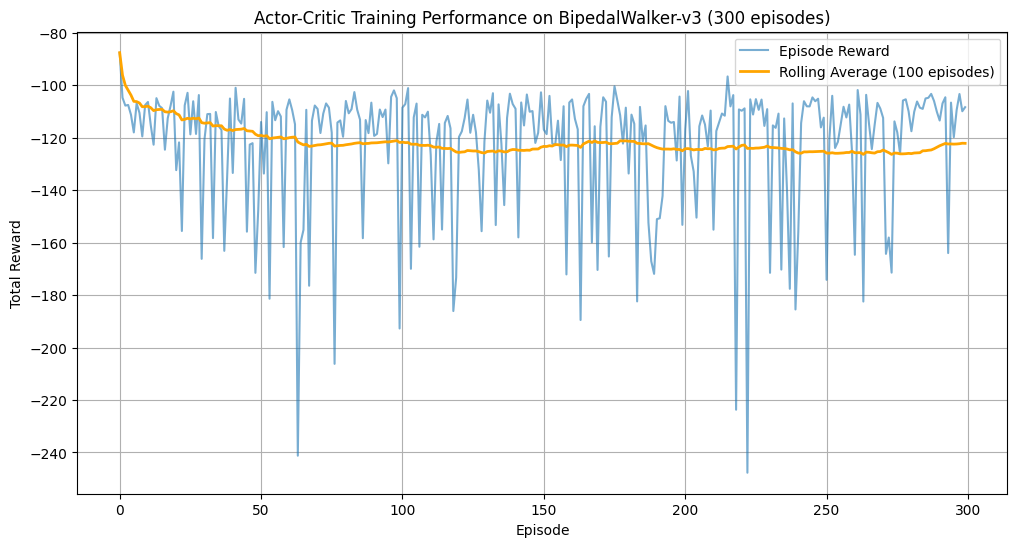


--- Starting Evaluation (10 episodes) ---
Models loaded from saved_models_300/actor_final.pth and saved_models_300/critic_final.pth
Evaluation Episode 1/10 | Reward: -103.40
Evaluation Episode 2/10 | Reward: -103.29


<ipython-input-2-875ee17e33ce>:309: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.actor.load_state_dict(torch.load(actor_path, map_location=DEVICE))
<ipython-input-2-87

Evaluation Episode 3/10 | Reward: -103.61
Evaluation Episode 4/10 | Reward: -103.37
Evaluation Episode 5/10 | Reward: -103.45
Evaluation Episode 6/10 | Reward: -103.19
Evaluation Episode 7/10 | Reward: -103.30
Evaluation Episode 8/10 | Reward: -103.05
Evaluation Episode 9/10 | Reward: -103.20
Evaluation Episode 10/10 | Reward: -103.54
--- Evaluation Finished ---
Average Reward over 10 episodes: -103.34 +/- 0.16
Evaluation Time: 0.79s
---------------------------



In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from collections import deque
import time
import os

en = "BipedalWalker-v3"
trm = None
erm = None
g = 0.99
lra = 3e-4
lrc = 5e-4
hs = 256
me = 300
mspe = 1600
li = 10
ec = 0.01
vlc = 0.5
cgn = 0.5
ee = 10
msd = "saved_models_300"
lss = 100
lsg = 0.9

d = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {d}")

class Actor(nn.Module):
    def __init__(self, sd, ad, hs):
        super(Actor, self).__init__()
        self.f1 = nn.Linear(sd, hs)
        self.f2 = nn.Linear(hs, hs)
        self.fm = nn.Linear(hs, ad)
        self.fls = nn.Linear(hs, ad)

    def forward(self, s):
        x = F.relu(self.f1(s))
        x = F.relu(self.f2(x))
        m = torch.tanh(self.fm(x))
        ls = self.fls(x)
        ls = torch.clamp(ls, min=-20, max=2)
        st = torch.exp(ls)
        return m, st

class Critic(nn.Module):
    def __init__(self, sd, hs):
        super(Critic, self).__init__()
        self.f1 = nn.Linear(sd, hs)
        self.f2 = nn.Linear(hs, hs)
        self.fv = nn.Linear(hs, 1)

    def forward(self, s):
        x = F.relu(self.f1(s))
        x = F.relu(self.f2(x))
        v = self.fv(x)
        return v

class ACA:
    def __init__(self, sd, ad, hs, lra, lrc, g, ec, vlc, cgn, lss=None, lsg=None):
        self.g = g
        self.ec = ec
        self.vlc = vlc
        self.cgn = cgn

        self.a = Actor(sd, ad, hs).to(d)
        self.c = Critic(sd, hs).to(d)

        self.ao = optim.Adam(self.a.parameters(), lr=lra)
        self.co = optim.Adam(self.c.parameters(), lr=lrc)

        self.as_ = None
        self.cs = None
        if lss is not None and lsg is not None:
            self.as_ = StepLR(self.ao, step_size=lss, gamma=lsg)
            self.cs = StepLR(self.co, step_size=lss, gamma=lsg)
            print(f"Using LR Schedulers: Step size {lss}, Gamma {lsg}")

        self.lp = []
        self.vs = []
        self.r = []
        self.e = []
        self.dn = []

    def select_action(self, s):
        s = torch.FloatTensor(s).unsqueeze(0).to(d)
        self.a.train()
        self.c.train()

        m, st = self.a(s)
        v = self.c(s)

        dt = Normal(m, st)
        ac = dt.sample()
        lp_ = dt.log_prob(ac).sum(axis=-1)
        e_ = dt.entropy().sum(axis=-1)

        self.lp.append(lp_)
        self.vs.append(v)
        self.e.append(e_)

        return ac.squeeze(0).cpu().numpy()

    def select_deterministic_action(self, s):
        s = torch.FloatTensor(s).unsqueeze(0).to(d)
        self.a.eval()
        with torch.no_grad():
            m, _ = self.a(s)
        return m.squeeze(0).cpu().numpy()

    def store_outcome(self, re, dn_):
        self.r.append(torch.tensor([re], dtype=torch.float32).to(d))
        self.dn.append(torch.tensor([dn_], dtype=torch.float32).to(d))

    def compute_returns_advantages(self, nv):
        ret = []
        adv = []

        nv = nv.to(d)

        R = nv
        for re, dn_, v in zip(reversed(self.r), reversed(self.dn), reversed(self.vs)):
            R = re + self.g * R * (1 - dn_)
            ret.insert(0, R)

            adv_ = R - v
            adv.insert(0, adv_)

        ret = torch.cat(ret).detach()
        adv = torch.cat(adv)

        if len(adv) > 1:
             adv = (adv - adv.mean()) / (adv.std() + 1e-8)
        elif len(adv) == 1:
             adv = (adv - adv.mean())

        return ret, adv

    def update(self, ns):
        if not self.r:
            return

        ns = torch.FloatTensor(ns).unsqueeze(0).to(d)
        self.c.eval()
        with torch.no_grad():
            nv = self.c(ns)
        self.c.train()

        ret, adv = self.compute_returns_advantages(nv)

        if adv is None or len(adv) == 0:
            self.lp = []
            self.vs = []
            self.r = []
            self.e = []
            self.dn = []
            return

        lp = torch.cat(self.lp)
        vs = torch.cat(self.vs)
        e = torch.cat(self.e)

        al = -(lp * adv.detach() + self.ec * e).mean()

        cl = F.mse_loss(vs, ret) * self.vlc

        self.ao.zero_grad()
        al.backward()
        torch.nn.utils.clip_grad_norm_(self.a.parameters(), self.cgn)
        self.ao.step()

        self.co.zero_grad()
        cl.backward()
        torch.nn.utils.clip_grad_norm_(self.c.parameters(), self.cgn)
        self.co.step()

        self.lp = []
        self.vs = []
        self.r = []
        self.e = []
        self.dn = []

    def step_schedulers(self):
        if self.as_:
            self.as_.step()
        if self.cs:
            self.cs.step()

    def save_models(self, dir_, afn="actor_final.pth", cfn="critic_final.pth"):
        os.makedirs(dir_, exist_ok=True)
        ap = os.path.join(dir_, afn)
        cp = os.path.join(dir_, cfn)
        torch.save(self.a.state_dict(), ap)
        torch.save(self.c.state_dict(), cp)
        print(f"Models saved to {ap} and {cp}")

    def load_models(self, dir_, afn="actor_final.pth", cfn="critic_final.pth"):
        ap = os.path.join(dir_, afn)
        cp = os.path.join(dir_, cfn)
        if os.path.exists(ap) and os.path.exists(cp):
            self.a.load_state_dict(torch.load(ap, map_location=d))
            self.c.load_state_dict(torch.load(cp, map_location=d))
            print(f"Models loaded from {ap} and {cp}")
        else:
            print(f"Error: Model files not found in {dir_}")
            raise FileNotFoundError("Could not load model weights.")

def evaluate_agent(en_, ne, ms, md, afn, cfn, rm=None):
    print(f"\n--- Starting Evaluation ({ne} episodes) ---")
    ee_ = gym.make(en_, render_mode=rm)
    sd = ee_.observation_space.shape[0]
    ad = ee_.action_space.shape[0]

    ea = ACA(sd, ad, hs, 0, 0, g, 0, 0, 0)

    try:
        ea.load_models(md, afn, cfn)
    except FileNotFoundError:
        print("Evaluation skipped as model files were not found.")
        ee_.close()
        return

    ea.a.eval()
    ea.c.eval()

    tr = []
    st_ = time.time()

    for ep in range(ne):
        s, i_ = ee_.reset()
        er = 0
        dn_ = False
        t = False

        for s_ in range(ms):
            ac = ea.select_deterministic_action(s)
            ns, re, ter, t, i_ = ee_.step(ac)
            dn_ = ter or t
            s = ns
            er += re
            if dn_:
                break
        tr.append(er)
        print(f"Evaluation Episode {ep + 1}/{ne} | Reward: {er:.2f}")

    ee_.close()
    ar = np.mean(tr)
    sr = np.std(tr)
    et = time.time() - st_
    print(f"--- Evaluation Finished ---")
    print(f"Average Reward over {ne} episodes: {ar:.2f} +/- {sr:.2f}")
    print(f"Evaluation Time: {et:.2f}s")
    print("---------------------------\n")

def train():
    ev = gym.make(en, render_mode=trm)

    sd = ev.observation_space.shape[0]
    ad = ev.action_space.shape[0]

    ag = ACA(sd, ad, hs,
             lra, lrc,
             g, ec, vlc, cgn,
             lss, lsg)

    ers = []
    rr = deque(maxlen=100)

    st_ = time.time()
    sl = False

    print(f"Starting training on {en} for {me} episodes...")
    print("NOTE: 300 episodes is likely too short to fully solve BipedalWalker-v3 with this A2C setup.")

    for ep in range(1, me + 1):
        s, i_ = ev.reset()
        er = 0
        dn_ = False
        t = False

        for s_ in range(mspe):
            ac = ag.select_action(s)

            ns, re, ter, t, i_ = ev.step(ac)
            dn_ = ter or t

            ag.store_outcome(re, ter)

            s = ns
            er += re

            if dn_:
                break

        ag.update(s)

        ag.step_schedulers()

        ers.append(er)
        rr.append(er)
        car = np.mean(list(rr))

        if ep % li == 0:
            et = time.time() - st_
            alr = ag.ao.param_groups[0]['lr']
            clr = ag.co.param_groups[0]['lr']
            print(f"Episode {ep}/{me} | Avg Reward (Last {min(ep, 100)}): {car:.2f} | Last Reward: {er:.2f} | Actor LR: {alr:.1e} | Critic LR: {clr:.1e} | Time: {et:.2f}s")

        if not sl and len(rr) == 100 and car >= 300:
            sl = True
            print(f"\nEnvironment considered SOLVED in {ep} episodes! Average reward: {car:.2f}")

    ev.close()
    ttt = time.time() - st_
    print(f"\nTraining finished after {ep} episodes.")
    print(f"Total Training Time: {ttt:.2f}s")

    afp = "actor_final.pth"
    cfp = "critic_final.pth"
    ag.save_models(msd, afp, cfp)

    plt.figure(figsize=(12, 6))
    plt.plot(ers, label='Episode Reward', alpha=0.6)
    if len(ers) >= 100:
        ra = [np.mean(ers[max(0, i-100):i+1]) for i in range(len(ers))]
        plt.plot(ra, label='Rolling Average (100 episodes)', color='orange', linewidth=2)
    else:
        sa = [np.mean(ers[:i+1]) for i in range(len(ers))]
        plt.plot(sa, label='Average Reward', color='orange', linewidth=2)

    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Actor-Critic Training Performance on {en} ({me} episodes)")
    plt.legend()
    plt.grid(True)
    pf = f"actor_critic_{en}_{me}_ep_rewards.png"
    plt.savefig(pf)
    print(f"Training reward plot saved to {pf}")
    # plt.show()

    if os.path.exists(os.path.join(msd, afp)):
        evaluate_agent(en, ee, mspe, msd, afp, cfp, rm=erm)
    else:
        print("\nSkipping final evaluation as model files were not saved (likely due to premature exit or error).")

if __name__ == '__main__':
    train()